# OOI RCA 2024 DAS -- Event Denoising and Detection

**Author:** Qibin Shi (qs20@rice.edu; qibin.nan@gmail.com)

**Last updated:** Dec 7, 2025

This notebook provides a demo on processing the data from the Ocean Observatories Initiative (OOI) 

Regional Cabled Array's Distributed Acoustic Sensing (DAS) to detect regional earthquakes.

## Overview

The data for this experiment was acquired using the OptoDAS system from Alcatel Subsea Networks. 

The focus was on the South Cable of the OOI RCA.

## Data Access (not for this tutorial)

The complete OptoDAS data can be accessed via the following link:

[OptoDAS Data Repository](http://piweb.ooirsn.uw.edu/das24/data/)

The data is organized into directories named by date. Here’s a breakdown:

- **200G**: 2024-05-06
- **617G**: 2024-05-07
- **617G**: 2024-05-08
- **617G**: 2024-05-09
- **382G**: 2024-05-10

For details on how to read and manipulate the HDF5 format data, refer to the

 [example code in this repository](https://github.com/uwfiberlab/OOI_DAS_2024).

## Cable Geometry

The map shows the OOI RCA cables (black lines) and the interrogated segment (red line) 

between the Oregon coast and the repeater (red dots). Bathymetric contours are in meters. 

The inset map indicates full-length cables, seafloor nodes, coastal lines, and plate boundaries.

![<img src="./utils_for_denodas/fig-OOIcable.jpg" width="600">](https://github.com/uwfiberlab/sz4d_das_workshop/blob/main/notebooks/qibin/utils_for_denodas/fig-OOIcable.jpg?raw=true)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc

import sys
sys.path.append('./utils_for_denodas/')

import h5py
import numpy as np

import torch
import torch.nn as nn
import seisbench.models as sbm

from das_util import *
from denodas_model import unet
from scipy.signal import filtfilt, butter, decimate
from scipy.interpolate import interp1d

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 22

import psutil, os
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

### Directory for data and denoising model
rawdata_dir = '/1-fnp/petasaur/p-wd02/muxDAS/'
rawdata_dir = '../../data/qibin/'
model_dir = './utils_for_denodas/denoiser_weights_LR08_MASK05_raw2raw_old.pt'
data_picked =  False

RSS GB: 0.52


## Associate DAS and seismic network phase picks

We have already picked phases on all regional stations for you.

Now you can use these picks to locate these sources generating T and S waves

In [22]:
import pyocto
## Initialize Octo
velocity_model = pyocto.VelocityModel1D("../models/vmodel/velocity_model", tolerance=2.0)

associator = pyocto.OctoAssociator.from_area(
    lat=(43, 48),
    lon=(-133, -123),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=3,
    n_p_picks=0,
    n_s_picks=2,
    n_p_and_s_picks=0,
)

In [23]:
import pandas as pd
### Read picks and stations
picks_sta = pd.read_csv('./utils_for_denodas/picks_octo_obs3-15hz_may10.csv')
picks_das = pd.read_csv('./utils_for_denodas/picks_octo_ooi_may10.csv')
sta_table = pd.read_csv('./utils_for_denodas/stations_table.csv')
channel_table = pd.read_csv('./utils_for_denodas/das_channel_table_ooi.csv')

### limit the time range
picks_sta['time']=picks_sta['time'].apply(UTCDateTime)
picks_sta = picks_sta[(picks_sta['time']>=UTCDateTime("2024-05-10T00:00:00")) & (picks_sta['time']<=UTCDateTime("2024-05-10T06:00:00"))]
picks_sta['time']=picks_sta['time'].apply(lambda x: x.timestamp)

picks_das['time']=picks_das['time'].apply(UTCDateTime)
picks_das = picks_das[(picks_das['time']>=UTCDateTime("2024-05-10T00:00:00")) & (picks_das['time']<=UTCDateTime("2024-05-10T06:00:00"))]
picks_das['time']=picks_das['time'].apply(lambda x: x.timestamp)

In [24]:
### Merge
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)
picks = pd.concat([picks_sta, picks_das], axis=0, ignore_index=True)

### Associate using DAS+STA
events, _ = associator.associate(picks, stations_table)

### Generate event list
associator.transform_events(events)
events['time'] = events['time'].apply(UTCDateTime)

In [25]:
### check memory usage
del picks_sta, picks_das, channel_table, stations_table, picks, associator
gc.collect()
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.34


In [26]:
### Discard events with less than 6 picks
events = events[events['picks']>=6]

### find the event time between 2024-05-10 02:45:00 and 2024-05-10 02:50:00, and simplify the dataframe to latitude, longitude, and time
events1 = events[(events['time']>=UTCDateTime("2024-05-10T02:45:00")) & (events['time']<=UTCDateTime("2024-05-10T02:50:00"))]
print(events1[['longitude', 'latitude']].to_string(index=False))

  longitude  latitude
-127.532488  43.47321


Plot detected events

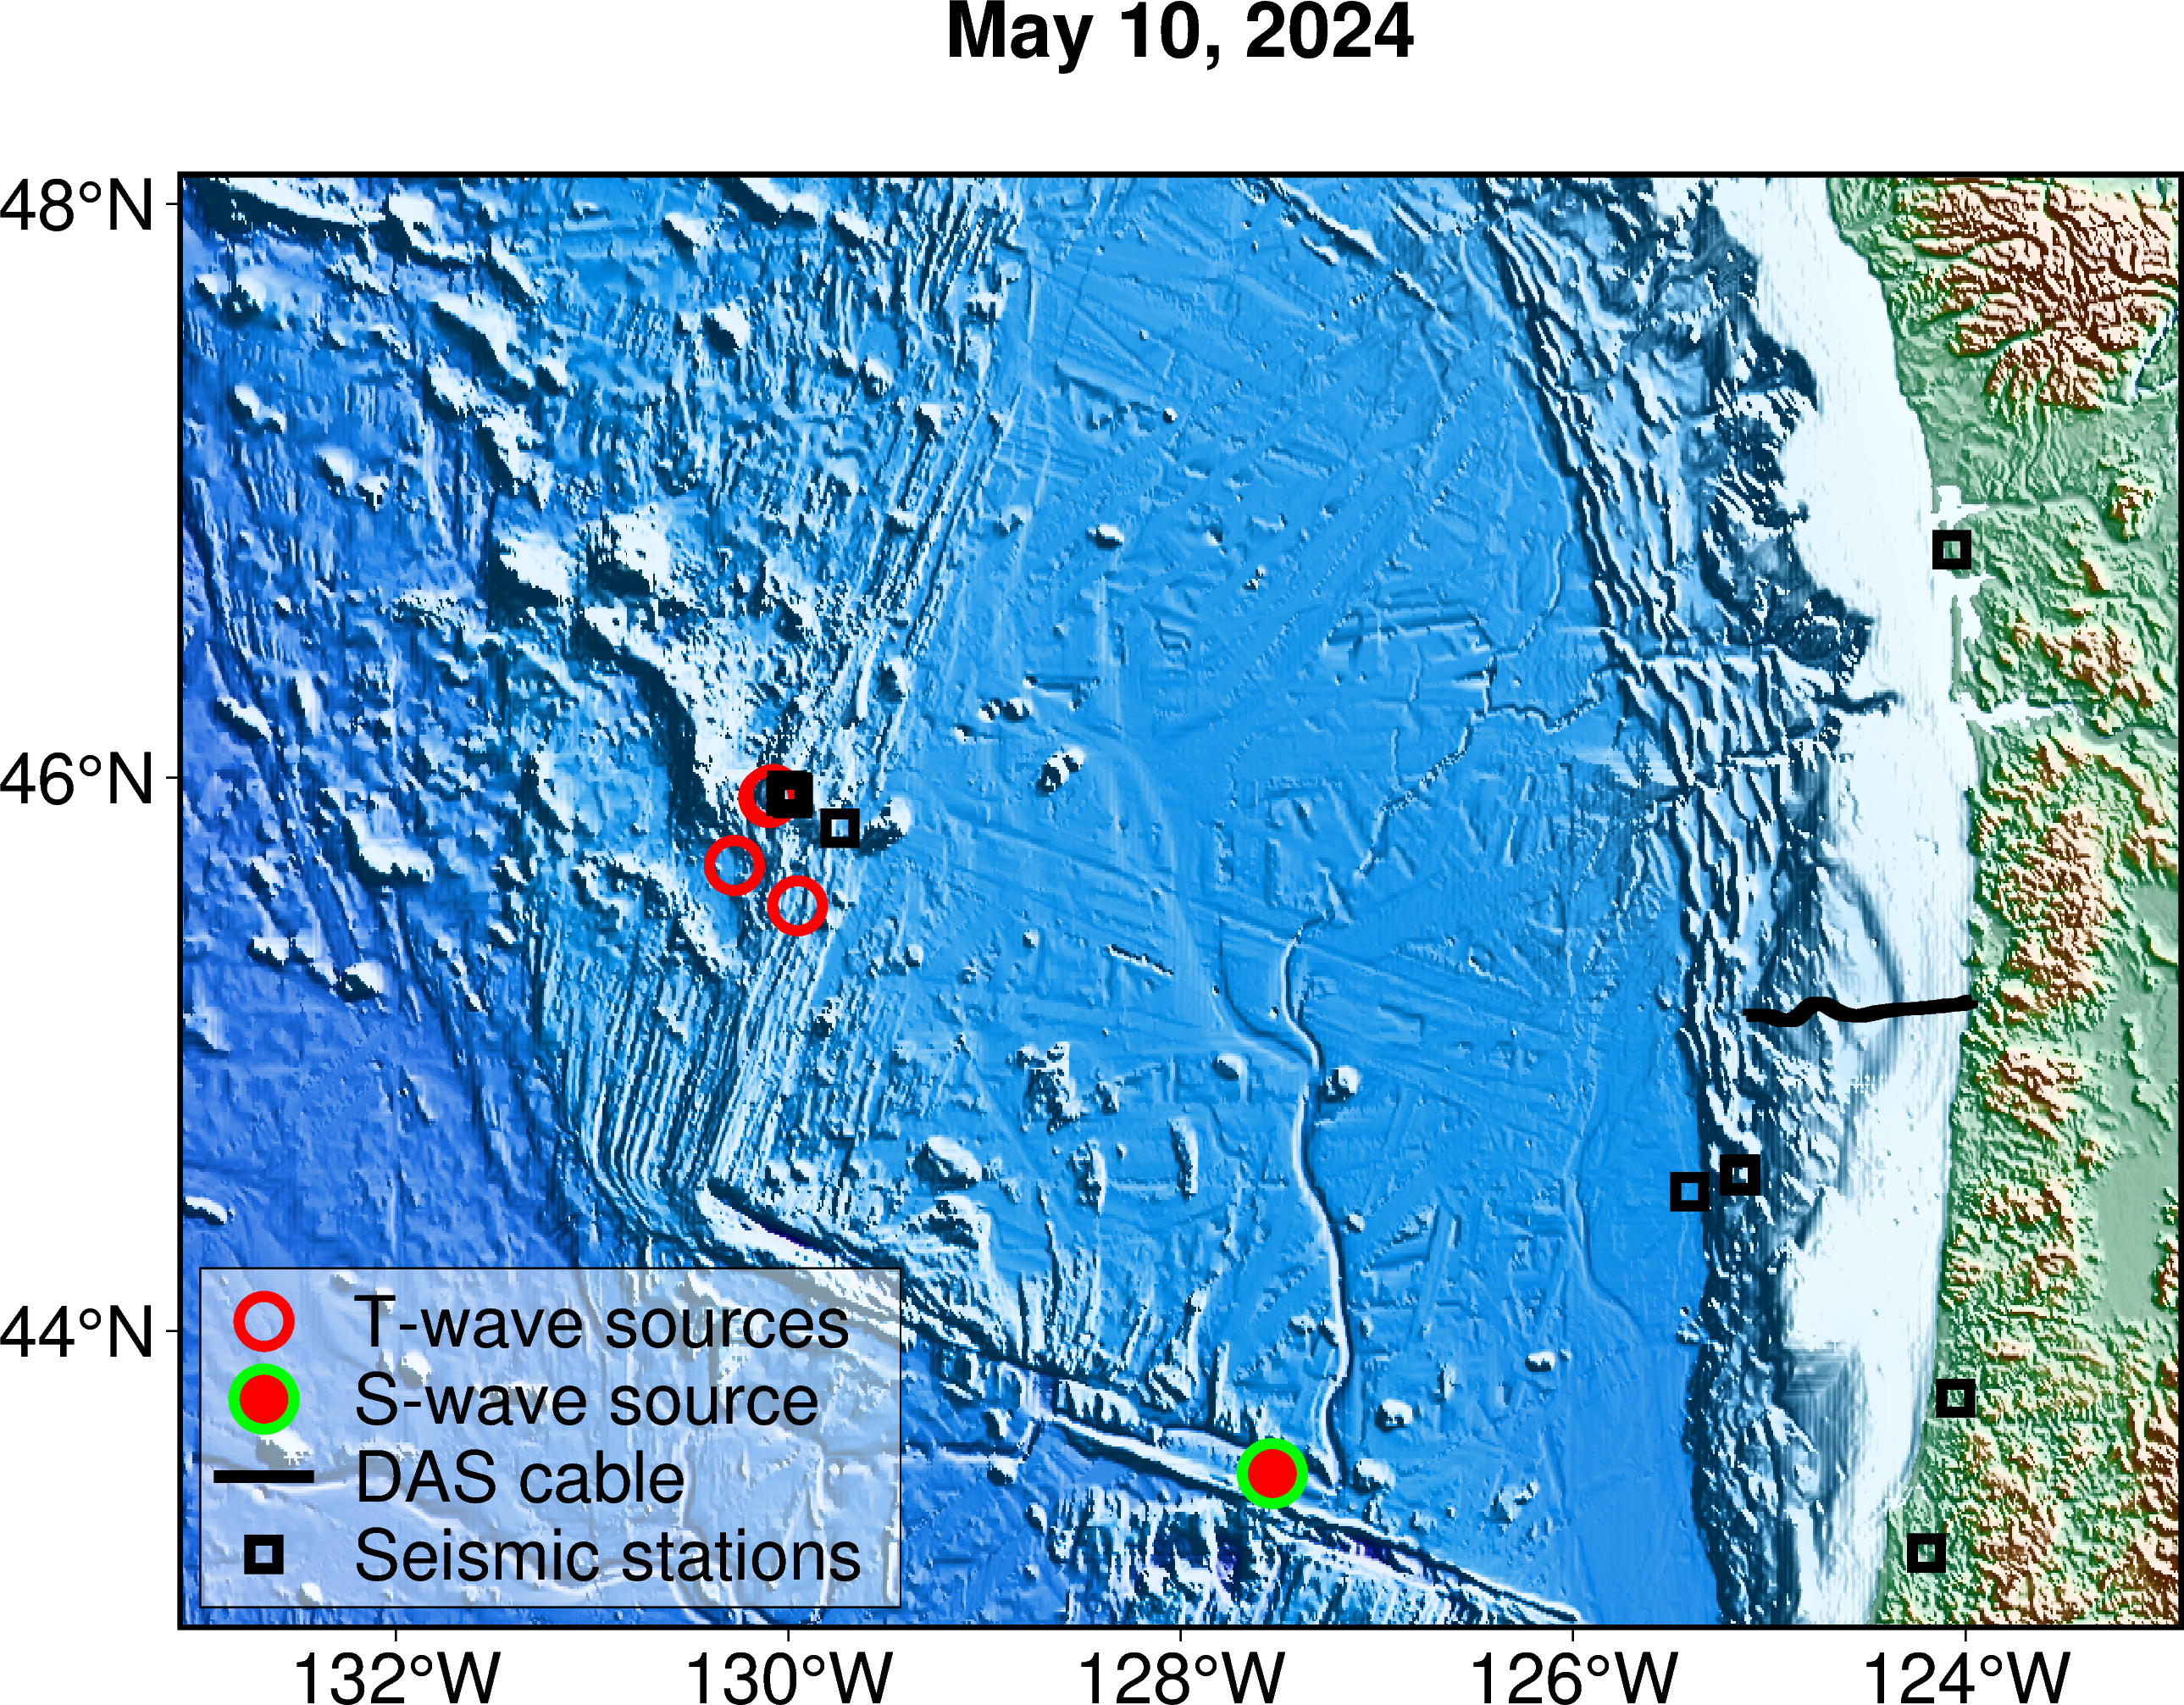

In [ ]:
import pygmt
import os
os.environ["LD_LIBRARY_PATH"] = "/srv/conda/envs/workshop/lib"

### Map
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="20p,0", FONT_ANNOT_PRIMARY="20p,0",
             FONT_ANNOT_SECONDARY="20p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-133.1, -122.9, 42.9, 48.1])
shade = pygmt.grdgradient(grid=grid, azimuth="0/90", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M20c",frame=["+tMay 10, 2024","a2"],cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])

### Plot detected events
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    style="c0.5c",
    pen="3p,red",
    label="T-wave sources"
)
fig.plot(
    x=events1["longitude"].values,
    y=events1["latitude"].values,
    style="c0.6c",
    pen="3p,green",
    fill="red",
    label="S-wave source"
)

### Plot cable line
fig.plot(
    x=lon,
    y=lat,
    pen="3.5p,black",
    label="DAS cable"
)

## plot stations
fig.plot(
    x=sta_table['longitude'].values,
    y=sta_table['latitude'].values,
    style="s0.4c",
    pen="3p,black",
    label="Seismic stations"
)

### Add legend
fig.legend(position="JBL+jBL+o0.2c+w7c", box="+gwhite@50+p0.5p")

fig.show()

In [28]:
### check memory usage
proc = psutil.Process(os.getpid())
print(f"RSS GB: {proc.memory_info().rss/1e9:.2f}")

RSS GB: 1.39


---

## Reference

- Self-supervised machine learing for DAS: https://github.com/Denolle-Lab/Shi_etal_2023_denoiseDAS
- Shi, Q., Williams, E. F., Lipovsky, B. P., Denolle, M. A., Wilcock, W. S., Kelley, D. S., & Schoedl, K. (2025). Multiplexed distributed acoustic sensing offshore central Oregon. Seismological Research Letters, 96(2A), 784-800.
- Shi, Q., Denolle, M. A., Ni, Y., Williams, E. F., & You, N. (2025). Denoising offshore distributed acoustic sensing using masked auto‐encoders to enhance earthquake detection. Journal of Geophysical Research: Solid Earth, 130(2), e2024JB029728.